In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
from urllib.parse import urlencode
from scipy import stats
import pingouin as pg
import scipy.stats as st
from scipy.stats import bootstrap
import scipy

In [24]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  # Сюда вписываете вашу ссылку
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('downloaded_file.csv', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

In [150]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anton-zhuravlev/downloaded_file.csv', sep=';')

In [151]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [152]:
df.shape

(404770, 3)

In [153]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [154]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

## Задание 2
## Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
## Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


### EDA анализ

Для начала выясним, где здесь контрольная, а где тестовая группы

In [155]:
df.query('testgroup == "a"')

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [156]:
df.query('testgroup == "a" & revenue > 0') # а - контрольная группа

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [157]:
control_group = df.query('testgroup == "a"') # завожу в переменную датафрейм для контрольной группы
control_group

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [158]:
df.query('testgroup == "b"')

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


In [159]:
df.query('testgroup == "b" & revenue > 0') 
# b - тестовая группа

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


In [160]:
test_group = df.query('testgroup == "b"') 
# завожу в переменную датафрейм для тестовой группы
test_group

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


### Метрики

Теперь посчитаем ARPU (average revenue per user) для каждой группы

In [161]:
arpu_control_group = control_group.revenue.sum() / control_group.user_id.count() 
# нахожу ARPU контрольной группы
arpu_control_group

25.413719736965806

In [162]:
arpu_test_group = test_group.revenue.sum() / control_group.user_id.count() 
# нахожу ARPU тестовой группы
arpu_test_group

26.825940238393294

In [163]:
(arpu_test_group - arpu_control_group) / arpu_control_group * 100 
# определяю на сколько (в %) выше ARPU контрольной группы

5.556921678699898

In [164]:
arppu_control_group = control_group.revenue.sum() / control_group.query('revenue > 0').user_id.count() # рассчитываю ARPPU контрольной группы
arppu_control_group

2663.9984439834025

In [165]:
arppu_test_group = test_group.revenue.sum() / test_group.query('revenue > 0').user_id.count() # рассчитываю ARPPU тестовой группы
arppu_test_group

3003.6581717451522

In [166]:
(arppu_test_group - arppu_control_group) / arppu_control_group * 100 
# определяю на сколько (в %) ARPPU тестовой группы выше

12.749997227996351

Посчитаем конверсию (Конверсия — это соотношение числа посетителей, выполнивших целевое действие из общего числа пользователей)

In [167]:
CR_control_group = control_group.query('revenue > 0').user_id.count() / control_group.user_id.count() * 100 # конверсия в платящих пользователей для контрольной группы
CR_control_group
# считаю конверсию в платящего пользователя контрольной группы

0.9539690157988748

In [168]:
CR_test_group = test_group.query('revenue > 0').user_id.count() / test_group.user_id.count() * 100 # конверсия в платящих пользователей для тестовой группы
CR_test_group
# считаю конверсию в платящего пользователя тестовой группы

0.8906235351586593

### Оценка АБ-тестов

А/Б тесты проводятся в 4 стадии: 1. выбор метрики; 2. разбить пользователей на 2 группы: система сплитования; 3.  рассчитываем объем выборки и длительность проведения эксперимента. 4. применяем правильный стат метод

In [169]:
control_group.user_id.count() - test_group.user_id.count()
# считаем разницу количества пользователей двух групп

-564

In [170]:
control_group.query('revenue > 0').user_id.count() - test_group.query('revenue > 0').user_id.count()
# считаем на сколько платящих пользователей больше в контрольной

123

In [171]:
test_group.query('revenue > 0').describe() 
# смотрим на основные стат показатели для платящих юзеров тестовой группы

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


In [172]:
control_group.query('revenue > 0').describe() 
# смотрим на основные стат показатели для платящих юзеров тестовой группы

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [173]:
control_group.query('revenue > 0').revenue.min()  - test_group.query('revenue > 0').revenue.min()
# смотрим насколько отличается минимальное значение выручки контрольной группы от тестовой

-1800

In [174]:
control_group.query('revenue > 0').revenue.max()  - test_group.query('revenue > 0').revenue.max()
# смотрим насколько отличается максимальное значение выручки контрольной группы от тестовой

33433

In [175]:
control_group.query('revenue > 0').revenue.median()  - test_group.query('revenue > 0').revenue.median()
# смотрим на отличие медиан 

-2711.0

In [176]:
control_group.query('revenue > 0').revenue.mean()  - test_group.query('revenue > 0').revenue.mean()
# смотрим на отличие средних

-339.65972776174976

Минимальные и максимальные значения выручки с платящих пользователей сильно различаются. Тестовая группа: от 2000 до 4000; Контрольная группа от 200 от 37433.

In [177]:
control_group.query('revenue > 0').revenue.quantile([0.25, 0.5, 0.6, 0.7, 0.8, 0.9]) 
# разобьем на квантили (процентные срезы) пользователей

0.25    257.0
0.50    311.0
0.60    333.2
0.70    351.9
0.80    372.6
0.90    393.3
Name: revenue, dtype: float64

In [178]:
control_group.query('revenue > 0').revenue.quantile([0.25, 0.5, 0.6, 0.7, 0.85, 0.9, 0.95]) 
# уменьшаю разбивку на квантили

0.25      257.00
0.50      311.00
0.60      333.20
0.70      351.90
0.85      381.95
0.90      393.30
0.95    37299.65
Name: revenue, dtype: float64

In [179]:
control_group.query('revenue > 37000').revenue.sum() 
# рассчитываю сумму выручки с пользователей, которые попали в 5%-ый срез (выброс)

4590252

In [180]:
(4590252 / control_group.query('revenue > 0').revenue.sum()) * 100 
# рассчитываю какой процент выручки принес тот 5-ый срез (выброс)

89.37077665950378

In [181]:
control_group.query('revenue > 37000').user_id.count() 
# считаю количество пользователей принесших 89% дохода в контрольной группе

123

#### Выводы:
В результате имеем 5% игроков, попавших в выбросы, предположительно, в результате неправильной стадии сплитования АБ теста. Считаю, на данном этапе следует исправить ошибку и перезапустить АБ тест, удалив часть игроков отличающихся от тех, что есть в группе. Как вариант, можно отбросить хвост (выброс) из игроков в количестве 123, отличающихся от всех в группе, при этом, конверсия в платящего пользователя в контрольной группе (0.95) станет равной в тестовой группе (0.89) и платящих пользователей станет столько же сколько в тестовой группе (1805).

Для начала проведу стат исследование на данных с 5% игроков

### Сравнение средних значений выручки с платящих пользователей тестовой и контрольной групп

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


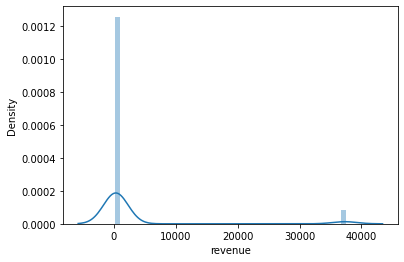

In [182]:
sns.distplot(control_group.query('revenue > 0').revenue) # распределение выручки контрольной группы на графике

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


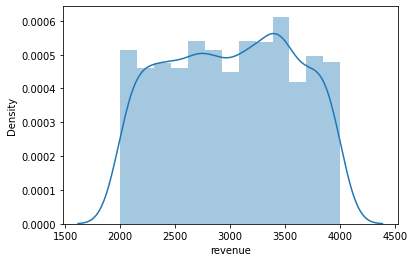

In [183]:
sns.distplot(test_group.query('revenue > 0').revenue) # распределение выручки тестовой группы на графике

In [184]:
pg.normality(data=test_group.query('revenue > 0'), dv="revenue", group="testgroup", method="normaltest")
# тест на нормальномсть тестовой группы

,W,pval,normal
b,1068.860008,7.943249e-233,False


In [185]:
pg.normality(data=control_group.query('revenue > 0'), dv="revenue", group="testgroup", method="normaltest")
# тест на нормальность контрольной группы

,W,pval,normal
a,1394.945784,1.234161e-303,False


Формулируем гипотезы:

Н0 - нулевая гипотеза говорит о том, что различий в средних значениях выручки нет;

Н1 - альтернативная гипотеза говорит о том, что имеются стат значимые различия в средних значениях выручки

Для сравнения средних буду использовать Т-тест, т.к. в выборках разные непересекающиеся сегменты пользователей и большой размер выборок

In [186]:
# т-тест пакета статс
st.ttest_ind(a=control_group.query('revenue > 0').revenue, 
             b=test_group.query('revenue > 0').revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

Вывод:

pvalue > 0.05. 

Таким образом, стат значимых различий между средними значениями выручки с платящих пользователей нет

### Сравнение средних значений выручки пользователей тестовой и контрольной групп

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


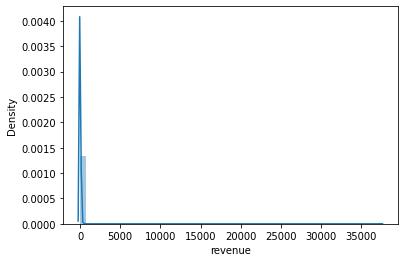

In [187]:
sns.distplot(control_group.revenue) # распределение выручки контрольной группы на графике

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


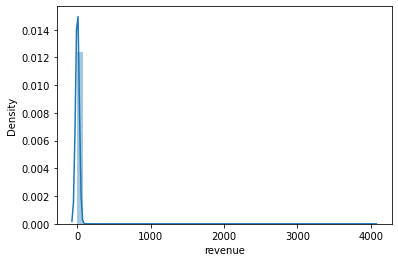

In [188]:
sns.distplot(test_group.revenue) # распределение выручки тестовой группы на графике

Очевидно, что значения распределены не нормально, но как и в предыдущем случае используем Т-тест, учитывая размер выборок

In [189]:
# т-тест пакета статс
st.ttest_ind(a=control_group.revenue, 
             b=test_group.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Вывод:

pvalue > 0.05. 

Таким образом, стат значимых различий между средними значениями выручки пользователей нет

### Сравнение конверсий двух групп

Найдем различия между конверсиями контрольной и тестовой группами

Пользователи разбиваются на категории платящий и неплатящий, то есть у нас 2 категориальные переменные, поэтому для оценки различий конверсий используем метод хи-квадрат

Нулевая гипотеза - статистически значимых различий между конверсиями двух групп нет. 

Альтернативная -  имеем стат значимые различия между конверсиями двух групп

In [190]:
df['category'] = df['revenue'].apply(lambda x: '1' if x > 0 else '0')
# зададим новый столбец в df2, где зададим две категории для платящих (category=1) и не платящих пользователей (category=0)

In [191]:
cross_df = df.groupby(['testgroup', 'category'], as_index = False).agg({'user_id':'count'})
# сгруппируем по группам и категориям, посчитав количество пользователей и там и там

In [192]:
cross_df = cross_df.pivot(index = 'category', columns = 'testgroup', values = 'user_id')
cross_df
# преобразуем данные в кросс таблицу

testgroup,a,b
category,,
0,200175,200862
1,1928,1805


In [193]:
scipy.stats.chi2_contingency(cross_df)[1]

0.03647561892312613

### Вывод1:
### Таким образом, в результате проведенного стат анализа метрик установлено следующее:
  - сравнение ARPU не дало стат значимых различий;
  - сравнение ARPPU не дало стат значимых различий;
  - CR стат значимо отличается.
#### Набор акционных предложений не дал стат значимых различий метрик связанных с полученной выручкой, однако CR отличается. 


Теперь проведу стат исследование на данных без 5% пользователей (хвоста) контрольной группы отбросив их

### Сравнение групп без "123 пользователей"

In [194]:
control_group2 = control_group.drop(index=[416, 4428, 5777, 8065, 8743, 9429, 10757, 14923, 19495, 21585, 23163, 26880, 34534, 36713, 38373, 41745, 43429, 44838, 51655, 53562, 65077, 70484, 74057, 76986, 76997, 81477, 85943, 88358, 101861, 103213, 103436, 114589, 118396, 118702, 121906, 125272, 126811, 129434, 135835, 140864, 142804, 142866, 143518, 144685, 158592, 162045, 162676, 167601, 171374, 173850, 174390, 174415, 175825, 179282, 179942, 183253, 192479, 194050, 196601, 198540, 202182, 204559, 207398, 211179, 215440, 215448, 229054, 235858, 240101, 240453, 241173, 241635, 244494, 254113, 255845, 256708, 263204, 268985, 276340, 281847, 282245, 282705, 287698, 290026, 295384, 298284, 299426, 301585, 309602, 312023, 313103, 317047, 317168, 320969, 321014, 321550, 322040, 322551, 326023, 327313, 328236, 328650, 328972, 329819, 333692, 335282, 341072, 343141, 343212, 343706, 347560, 348056, 349990, 350738, 354631, 355154, 356812, 359915, 360696, 378668, 389341, 394580, 399294])
control_group2
# удаляем по индексу все отличающиеся значения столбцов (выбросы) из контрольной группы

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [195]:
arppu_control_group2 = control_group2.revenue.sum() / control_group2.query('revenue > 0').user_id.count() # рассчитываю ARPPU контрольной группы
arppu_control_group2
# рассчитываю ARPPU контрольной группы

302.45817174515236

In [196]:
arpu_control_group2 = control_group2.revenue.sum() / control_group2.user_id.count() 
arpu_control_group2
# рассчитываю ARPU контрольной группы

2.702926032280424

In [197]:
CR_control_group2 = control_group2.query('revenue > 0').user_id.count() / control_group2.user_id.count() * 100 # конверсия в платящих пользователей для контрольной группы
CR_control_group2
# считаю конверсию в платящего пользователя контрольной группы

0.893652836914546

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


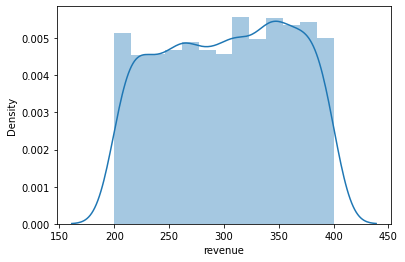

In [198]:
sns.distplot(control_group2.query('revenue > 0').revenue)  
# распределение выручки платящих пользователей в контрольной группе

В результате очевидно, что метрики тестовой группы значительно отличаются (ARPU=26.8, ARPPU=3003.7, CR=0.89)  от метрик контрольной (ARPU=2.7, ARPPU=302, CR=0.89), но мы теперь знаем статистику и статистические методы, поэтому применим их для поиска различий.

In [199]:
pg.normality(data=test_group.query('revenue > 0'), dv="revenue", group="testgroup", method="normaltest")
# проверка на нормальность тестовой группы через пакет пингвин

,W,pval,normal
b,1068.860008,7.943249e-233,False


In [200]:
pg.normality(data=control_group2.query('revenue > 0'), dv="revenue", group="testgroup", method="normaltest")
# проверка на нормальность тестовой группы через пакет пингвин

,W,pval,normal
a,1341.200992,5.779697e-292,False


In [201]:
control_group2.revenue.std()
# считаем стандартное отклонение новой контрольной группы

28.98581484732641

In [202]:
test_group.revenue.std()
# считаем стандартное отклонение тестовой гоуппе

287.32416166927845

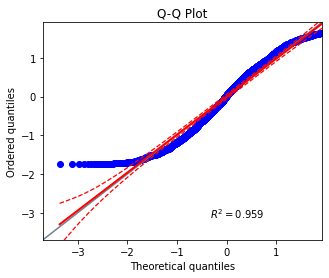

In [203]:
pg.qqplot(test_group.query('revenue > 0').revenue)
# смотрим на нормальность распределения выручки платящих пользователей тестовой группы на графике (quantile-quantile)

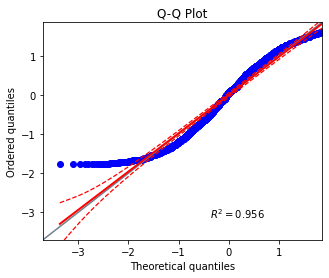

In [204]:
pg.qqplot(control_group2.query('revenue > 0').revenue)
          # смотрим на нормальность распределения выручки платящих пользователей тестовой группы на графике (quantile-quantile)

Распределения распределены не нормально, однако мы имеем большой размер выборки и отсутствие заметных выбросов. Попробуем использовать тест Стьюдента (т-тест). 

Нулевая гипотеза - различий между средними значениями выручки в группах нет. 

Альтернативная гипотеза - стат значимые различия имеются

In [205]:
# т тест пакета stats на метрике ARPPU
st.ttest_ind(a=control_group2.query('revenue > 0').revenue, 
             b=test_group.query('revenue > 0').revenue, equal_var=True)

Ttest_indResult(statistic=-199.39722533995328, pvalue=0.0)

In [206]:
# т тест пакета stats на метрике ARPU
st.ttest_ind(a=control_group2.revenue, 
             b=test_group.revenue, equal_var=True)

Ttest_indResult(statistic=-37.42623596967759, pvalue=4.912187544972622e-306)

pvalue=0 
Таким образом, вероятность отсутствия различий между средними значениями выручки контрольной группы и тестовой стремится к нулю. Получаем стат значимые различия, а значит примененный набор аукционных предложений к тестовой группе оказался лучшим, в случае отсутствия 123 пользователей в контрольной группе, которые явно отличаются от остальных в той же группе

Теперь с помощью статистики найдем различия между конверсиями новой контрольной и тестовой группами

Пользователи разбиваются на категории платящий и неплатящий, то есть у нас 2 категориальные переменные, поэтому для оценки различий конверсий используем метод хи-квадрат

Нулевая гипотеза - статистически значимых различий между конверсиями двух групп нет. Альтернативная -  имеем стат значимые различия между конверсиями двух групп

In [207]:
df2 = df.drop(index=[416, 4428, 5777, 8065, 8743, 9429, 10757, 14923, 19495, 21585, 23163, 26880, 34534, 36713, 38373, 41745, 43429, 44838, 51655, 53562, 65077, 70484, 74057, 76986, 76997, 81477, 85943, 88358, 101861, 103213, 103436, 114589, 118396, 118702, 121906, 125272, 126811, 129434, 135835, 140864, 142804, 142866, 143518, 144685, 158592, 162045, 162676, 167601, 171374, 173850, 174390, 174415, 175825, 179282, 179942, 183253, 192479, 194050, 196601, 198540, 202182, 204559, 207398, 211179, 215440, 215448, 229054, 235858, 240101, 240453, 241173, 241635, 244494, 254113, 255845, 256708, 263204, 268985, 276340, 281847, 282245, 282705, 287698, 290026, 295384, 298284, 299426, 301585, 309602, 312023, 313103, 317047, 317168, 320969, 321014, 321550, 322040, 322551, 326023, 327313, 328236, 328650, 328972, 329819, 333692, 335282, 341072, 343141, 343212, 343706, 347560, 348056, 349990, 350738, 354631, 355154, 356812, 359915, 360696, 378668, 389341, 394580, 399294])
df2.head()
# предобработаем данные, удалив 123 пользователя в общей таблице и сохраним датафрейм в новую переменную

,user_id,revenue,testgroup,category
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [208]:
df2['category'] = df2['revenue'].apply(lambda x: '1' if x > 0 else '0')
# зададим новый столбец в df2, где зададим две категории для платящих (category=1) и не платящих пользователей (category=0) 

In [209]:
cross_df2 = df2.groupby(['testgroup', 'category'], as_index = False).agg({'user_id':'count'})
# сгруппируем по группам и категориям, посчитав количество пользователей и там и там

In [211]:
cross_df2 = cross_df2.pivot(index = 'category', columns = 'testgroup', values = 'user_id')
cross_df2
# преобразуем данные в кросс таблицу

testgroup,a,b
category,,
0,200175,200862
1,1805,1805


In [212]:
scipy.stats.chi2_contingency(cross_df2)[1]

0.9316668591658103

p-value > 0.05. С вероятностью 93% стат значимых различий между конверсиями новой контрольной и тестовой группы нет. Таким образом, наборы акционных предложений не повлияли на конверсии в платящего пользователя двух групп.

### Вывод 2:
### В результате исследования, проведенного на выборках, отбросив хвост из контрольной группы мы получаем следующее:
- ARPPU стат значимо отличается (выше у тестовой группы);
- ARPU стат значимо отличается (выше у тестовой группы);
- CR стат значимых отличий нет.

Значит примененный набор аукционных предложений к тестовой группе оказался лучшим, в случае отсутствия 123 пользователей в контрольной группе, которые явно отличаются от остальных в той же группе

## Итоговый Вывод:


### - Набор акционных предложений не дал стат значимых различий метрик, связанных с полученной выручкой, однако CR отличается. 

### - В результате анализа установил, что  в данных имеется 5% игроков, попавших в выбросы, предположительно, в результате неправильной стадии сплитования АБ теста. Следует выявленную ошибку исправить и перезапустить АБ тест. Как вариант, можно отбросить хвост (выброс) из игроков в количестве 123, явно отличающихся от других в группе и провести повторно стат исследование на выявление эффективности акционных предложений.

### - В результате исследования, проведенного на выборках, отбросив хвост из контрольной группы получил стат значимые отличия метрик, связанных с полученной выручкой при той же конверсии в платящего пользователя. Набор акционных предложений к тестовой группы оказался лучшим
